<a href="https://colab.research.google.com/github/MurtazAlek/MLDM-2021/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22MLDM_2020_seminar07_Ensembles_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ensembles: bagging & boosting

### Preliminary things (from the last seminar)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

Here's a function that makes a 2d decision boundary plot for a given classifier:

In [ ]:
from sklearn.metrics import accuracy_score

def plot_decision_surface(
                  clf, X, y,
                  nx=200, ny=100,
                  cmap='bwr',
                  alpha=0.6,
        ):
    """
    Plot the decision boundary of clf on X and y, visualize training points
    """
    
    # Define the grid
    x_top_left = X.min(axis=0) - 1
    x_bottom_right = X.max(axis=0) + 1
    grid_x0, grid_x1 = np.meshgrid(
         np.linspace(x_top_left[0], x_bottom_right[0], ny),
         np.linspace(x_top_left[1], x_bottom_right[1], nx)
      )
    
    # Calculate predictions on the grid
    y_pred_grid = clf.predict(
                        np.stack(
                              [
                                grid_x0.ravel(),
                                grid_x1.ravel()
                              ],
                              axis=1
                            )
                      ).reshape(grid_x1.shape)
    
    # Find optimal contour levels and make a filled
    # contour plot of predictions
    labels = np.sort(np.unique(y))
    labels = np.concatenate([[labels[0] - 1],
                             labels,
                             [labels[-1] + 1]])
    medians = (labels[1:] + labels[:-1]) / 2
    plt.contourf(grid_x0, grid_x1, y_pred_grid, cmap=cmap, alpha=alpha,
                 levels=medians)
    
    # Scatter data points on top of the plot,
    # with different styles for correct and wrong
    # predictions
    y_pred = clf.predict(X)
    plt.scatter(*X[y_pred==y].T, c=y[y_pred==y],
                marker='o', cmap=cmap, s=10, label='correct')
    plt.scatter(*X[y_pred!=y].T, c=y[y_pred!=y],
                marker='x', cmap=cmap, s=50, label='errors')

    # Dummy plot call to print the accuracy in the legend.
    plt.plot([], [], ' ',
             label='Accuracy = {:.3f}'.format(accuracy_score(y, y_pred)))
    
    plt.legend(loc='best')

#### Toy multiclass data

In [ ]:
!wget https://github.com/HSE-LAMBDA/MLDM-2020/raw/master/day-06/data.npz

--2021-07-30 19:07:24--  https://github.com/HSE-LAMBDA/MLDM-2020/raw/master/day-06/data.npz
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/HSE-LAMBDA/MLDM-2020/master/day-06/data.npz [following]
--2021-07-30 19:07:24--  https://raw.githubusercontent.com/HSE-LAMBDA/MLDM-2020/master/day-06/data.npz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 108474 (106K) [application/octet-stream]
Saving to: ‘data.npz’

data.npz            100%[===================>] 105.93K  --.-KB/s    in 0.02s   

2021-07-30 19:07:24 (6.71 MB/s) - ‘data.npz’ saved [108474/108474]



Firstly, we'll load the data:

In [ ]:
data = np.load('data.npz')
X, y = data["X"], data["y"]

print(X.shape, y.shape)

(4505, 2) (4505,)


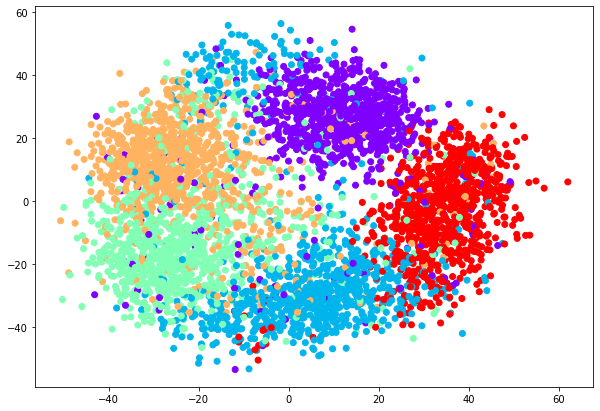

In [ ]:
plt.figure(figsize=(10, 7))
plt.scatter(*X.T, c=y, cmap='rainbow');

And then split it to train and test:

In [ ]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.5, random_state=1337)

Now that we've had a look at the data, let's fit a decision tree on it:

In [ ]:
clf = DecisionTreeClassifier(min_samples_leaf=12)
clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=12, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

and plot the result:

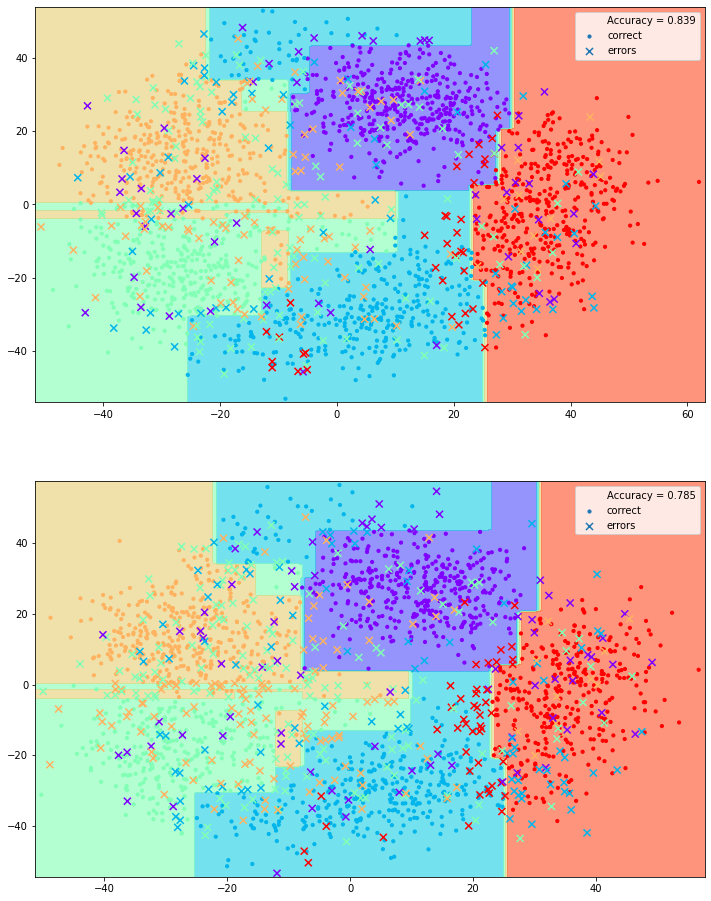

In [ ]:
plt.figure(figsize=(12, 16))
plt.subplot(2, 1, 1)
plot_decision_surface(clf, X_train, y_train, cmap='rainbow')
plt.subplot(2, 1, 2)
plot_decision_surface(clf, X_test, y_test, cmap='rainbow');

```

```

```

```

```

```

```

```

## Ensembles

### Bagging

Let's build our own decision tree bagging and see how well it works. Implement the **`BagOfTrees`** class below:

In [ ]:
class BagOfTrees:
  def __init__(self, n_estimators=10, **kwargs):
    self.trees = []
    for i in range(n_estimators):
        self.trees.append(DecisionTreeClassifier(**kwargs))
        
  def fit(self, X, y):
        trees = self.trees
        for tree in trees:
            ix = np.random.randint(0, len(X), len(X))
            X_sample, y_sample = X[ix], y[ix]
            tree.fit(X_sample, y_sample)


  def predict(self, X):
        trees = self.trees
        ans=[]
        for tree in trees:
            ans_prob=(tree.predict_proba(X))
            ans.append(ans_prob)
        return np.array(ans).mean(axis=0).argmax(axis=1)
  
# once you think you're done, see if your code passes the asserts below

In [ ]:
model = BagOfTrees(n_estimators=100, min_samples_leaf=3)
model.fit(X_train, y_train)

pred = model.predict(X_test[::100])
print("predictions:", pred)
assert isinstance(pred, np.ndarray), "prediction must be a numpy array"
assert str(pred.dtype).startswith('int'), "prediction dtype must be integer (int32/int64)"
assert pred.ndim == 1, "prediction must be a vector (1-dimensional)"
assert len(pred) == len(X_test[::100]), "must predict exactly one answer for each input (expected length %i, got %i)" % (len(X_test[::100]), len(pred))
assert any(model.trees[0].predict(X_train) != model.trees[1].predict(X_train)), "Some trees are identical. Did you forget to train each tree on a random part of the data?"

predictions: [0 3 0 0 0 1 2 3 4 3 0 3 2 0 2 1 1 0 1 3 1 2 2]


If the cell above executes without errors, run the code below to compare overall accuracy with individual tree accuracies:

In [ ]:
for i, tree in enumerate(model.trees[:5]):
    print("tree {} individual accuracy = {:.5f}".format(
        i, accuracy_score(y_test, tree.predict(X_test))
      ))

print("Ensemble accuracy:",
      accuracy_score(model.predict(X_test), y_test)) # should be >= 0.78

tree 0 individual accuracy = 0.72614
tree 1 individual accuracy = 0.71593
tree 2 individual accuracy = 0.69419
tree 3 individual accuracy = 0.72526
tree 4 individual accuracy = 0.71993
Ensemble accuracy: 0.7851753217931646


And have a look at the decision surface:

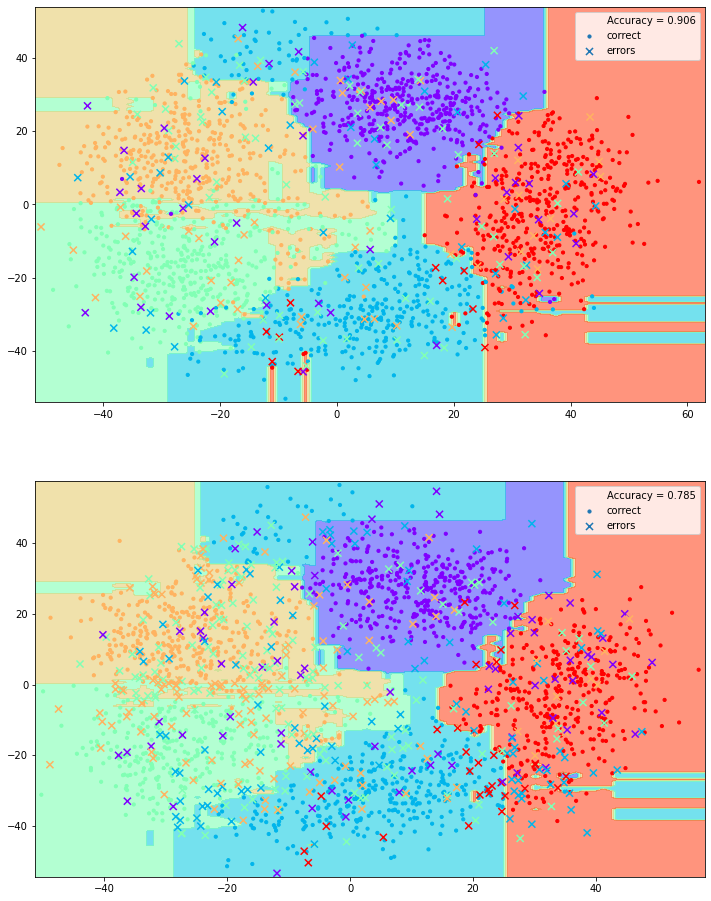

In [ ]:
plt.figure(figsize=(12, 16))
plt.subplot(2, 1, 1)
plot_decision_surface(model, X_train, y_train, cmap='rainbow')
plt.subplot(2, 1, 2)
plot_decision_surface(model, X_test, y_test, cmap='rainbow');

Now let's check how train and test accuracy depends on the number of estimators.

Hint: instead of fitting a new BagOfTrees for each number of estimators we can just fit the maximum number and then iteratively predict and remove the fitted trees one by one.

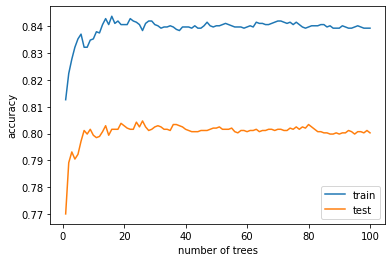

In [ ]:
model = BagOfTrees(n_estimators=100, min_samples_split=30, splitter='random', random_state=42)
model.fit(X_train, y_train)

n_trees = []
test_score = []
train_score = []

while model.trees:
  n_trees.append(len(model.trees))
  train_score.append(accuracy_score(y_train,model.predict(X_train)))
  test_score.append(accuracy_score(y_test,model.predict(X_test)))
  model.trees.pop()


plt.plot(n_trees, train_score, label='train')
plt.plot(n_trees, test_score, label='test')
plt.legend()
plt.xlabel('number of trees')
plt.ylabel('accuracy');

```
```
```
```
```
```

### Pre-implemented ensembles: Random Forest

RandomForest combines bagging and random subspaces: each tree uses a fraction of training samples, and the splits are chosen among subsets of features. Typically this leads to a slightly better performance.

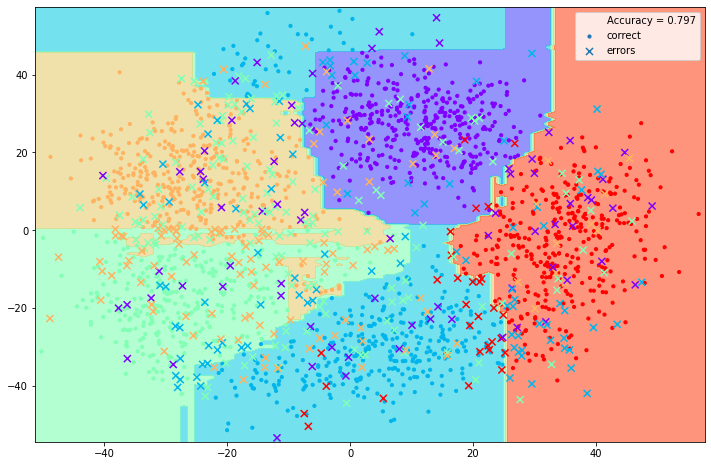

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Task: create and fit a random forest with
# 100 estimators and at least 5 samples per leaf

model = RandomForestClassifier(n_estimators=100, min_samples_leaf=5, bootstrap=True )
model.fit(X_train,y_train)

plt.figure(figsize=(12, 8))
plot_decision_surface(model, X_test, y_test, cmap='rainbow')

```
```
```
```

### Pre-implemented ensembles: Gradient Boosting

One of the most commonly used libraries for gradient boosing is the [XGBoost library](https://xgboost.ai/). Consider reading [this document](https://xgboost.readthedocs.io/en/latest/tutorials/model.html) for an introduction to the algorithm.

Here's the [help page](https://xgboost.readthedocs.io/en/latest/parameter.html) listing available parameters.

Let's start by importing the classifier class and the function that plots individual trees as graphs:

In [ ]:
from xgboost import XGBClassifier, plot_tree

We can now investigate how decision surface depends on the number of trees:

In [ ]:
for n_estimators in range(1,10):
    model = <YOUR CODE> # create an XGBClassifier with trees of depth 1,
                        # learning rate 0.5 and n_estimators estimators

    <YOUR CODE> # fit this model to the train data

    print("n_estimators = ", n_estimators)
    plt.figure(figsize=(8, 5))
    plot_decision_surface(model, X_test, y_test, cmap='rainbow')
    plt.show()

And here's how one may use the `plot_tree` function:

In [ ]:
fig, ax = plt.subplots(figsize=(12, 9))
plot_tree(model, num_trees=44, ax=ax, dpi='400');
#                   ^^^ This parameter selects the
#                       tree that you want to plot.
#                       Since there's 9 estimators
#                       in the last model and 5
#                       classes in our data, the total
#                       amount of individual trees
#                       is 45 (from 0 to 44).

<font color='red'>**Warning:**</font> current xgboost implementation is not very safe to typos, i.e. it can silently swallow whatever argument you provide, even if it has no effect, e.g.:

In [ ]:
model = XGBClassifier(abrakadabra="I won't change anything")
model

so be sure to check your spelling.

Now let's try to improve the score by adjusting the parameters. Here are some of the parameters you may want to try:
  - `max_depth` – maximum tree depth,
  - `n_estimators` – number of trees (per class),
  - `learning_rate` – shrinkage,
  - `reg_lambda` – L2 regularization term on weights,
  - `subsample` – row random subsampling rate (per tree),
  - `colsample_bynode` – column subsampling rate (per node)
  - `gamma` – minimum loss reduction required to make a further partition on a leaf node of the tree

See [this page](https://xgboost.readthedocs.io/en/latest/parameter.html) for more information.

  > *Hint: since XGBClassifier has the same interface as sklearn models, you can use GridSearchCV on it if you want.* 

In [ ]:
model = <YOUR CODE HERE>

model.fit(X_train, y_train)

plt.figure(figsize=(8, 5))
plot_decision_surface(model, X_test, y_test, cmap='rainbow')
plt.show();

```
```
```
```

## Feature importance

For this example we are going to use California Housing Dataset.

The **target** variable is the median house value for California districts.


The features are:
 *   **MedInc** median income in block
 *   **HouseAge** median house age in block
 *   **AveRooms** average number of rooms
 *   **AveBedrms** average number of bedrooms
 *   **Population** block population
 *   **AveOccup** average house occupancy
 *   **Latitude** house block latitude
 *   **Longitude** house block longitude
 
 More information [here](https://scikit-learn.org/stable/datasets/index.html#california-housing-dataset).

In [ ]:
from sklearn.datasets import fetch_california_housing
import pandas as pd

In [ ]:
dataset = fetch_california_housing()

`dataset` holds the data in numpy arrays, but we can convert it to a pandas dataframe:

In [ ]:
data = pd.DataFrame(dataset.data, columns=dataset.feature_names)
data['target'] = dataset.target

data.head(10)

Now, let's separate the features from the target and split the data to train and test parts:

In [ ]:
data_X = <YOUR CODE>
data_y = <YOUR CODE>

X_train, X_test, y_train, y_test = <YOUR CODE> # make a 50:50 split

and grid search for best random forest parameters on it:

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

model = RandomForestRegressor(n_estimators=30)

gscv = GridSearchCV(model,
                    param_grid=<YOUR CODE HERE>,
                    scoring='neg_mean_squared_error',
                    n_jobs=-1,
                    cv=3,
                    verbose=3)


gscv.fit(X_train, y_train)
model = gscv.best_estimator_
print(model)

print("Train loss:", mean_squared_error(y_train, model.predict(X_train)))
print("Test loss:" , mean_squared_error(y_test , model.predict(X_test )))

Once fit, the model has the information about importances of individual features, calculated from gain in individual splits.

In [ ]:
# get the estimates of feature importances
importances = model.feature_importances_
# calculate the std:
std = np.std([tree.feature_importances_ for tree in model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# This part will be used to make nice x-axis labels
# (we'll tell matplotlib to convert numeric feature
# index to a text label):
from matplotlib.ticker import FuncFormatter, MaxNLocator
def format_fn(tick_val, tick_pos):
    if int(tick_val) in range(len(importances)):
        return dataset.feature_names[int(tick_val)]
    else:
        return ''

fig, ax = plt.subplots(figsize=(13,7))
ax.set_title("Feature importances")
ax.xaxis.set_major_formatter(FuncFormatter(format_fn))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.bar(range(len(importances)), importances[indices],
       color="r", yerr=std[indices], align="center")
ax.set_xlim([-1, len(importances)])
plt.show();